In [1]:
# !pip install scipy
# !pip install graphviz
# !pip install xgboost
# !pip install kaggle
# !pip install kagglehub
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install xgboost
# !pip install graphviz

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap 

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

import xgboost

from graphviz import Source
from IPython.display import SVG

import itertools

import time

## Downloading, Studying and Cleaing

In [3]:
download_path = './hr_dataset'  # Folder where the CSV will be saved
file_name = 'HR_DataSet.csv'

if file_name in os.listdir(download_path):
    print('Using the exsiting file: {}'.format(file_name))
else:
    # the Kaggle API credentials
    import kaggle
    from kaggle.api.kaggle_api_extended import KaggleApi
    # Initialize Kaggle's API
    api = KaggleApi()
    api.authenticate()

    # Download the dataset
    dataset = 'manidevesh/hr-dataset-analysis'
    api.dataset_download_files(dataset, path=download_path, unzip=True)

    file_name = [f for f in os.listdir(download_path) if f.split('.')[1]=='csv'][0]
    print("Download complete. File name is: {}".format(file_name))


Using the exsiting file: HR_DataSet.csv


In [4]:
# Download the dataset
Data = pd.read_csv(os.path.join(download_path, file_name))

In [5]:
display(Data.head())

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
# There are no Nulls!
display(Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


None

In [7]:
# Number of duplicates
print(Data[Data.duplicated(list(Data.columns))].shape[0])

3008


In [8]:
# Example of duplicates
display(Data.query('satisfaction_level == 1.00 and last_evaluation == 0.93 and Department == "marketing"'))

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
10691,1.0,0.93,5,231,2,0,0,0,marketing,medium
12902,1.0,0.93,5,231,2,0,0,0,marketing,medium


#### I decided to keep the duplicates since for the given amount of data it may represent two different datapoints with coinciding inputs!

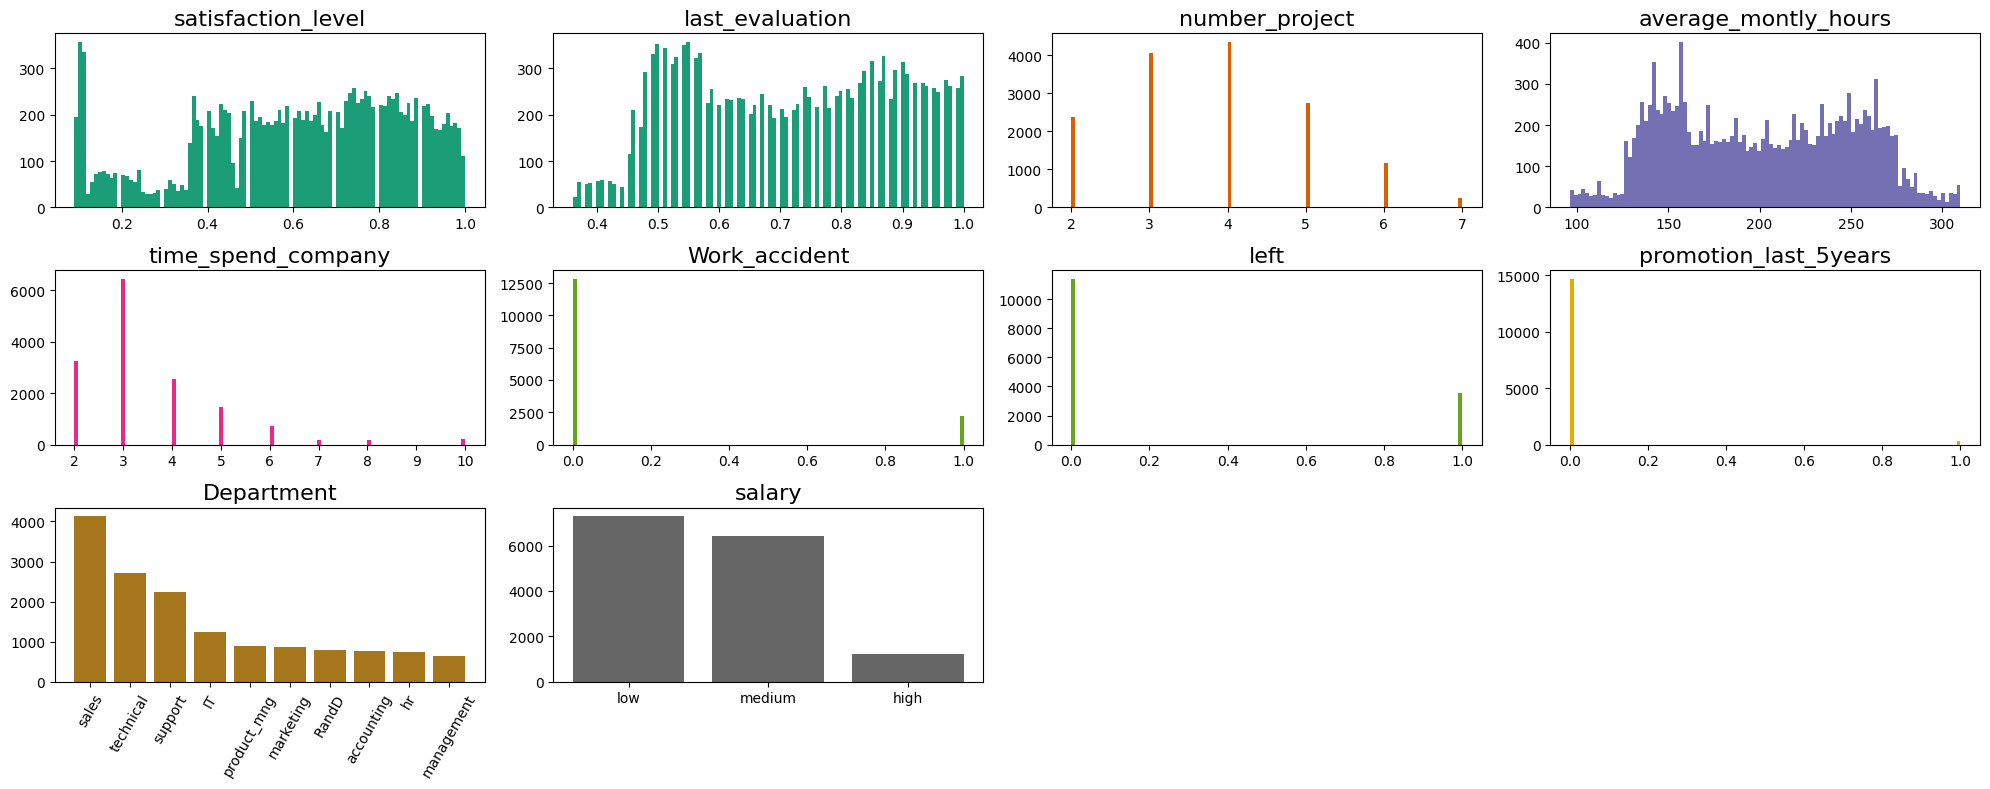

In [9]:
# Histograms
fig = plt.figure(figsize = (20, 8))
for idx, col, t in Data.dtypes.reset_index().reset_index().values:
    color = plt.colormaps.get_cmap('Dark2')(idx / Data.columns.size)
    if t == 'object':
        fig.add_subplot(3, 4, idx + 1).bar(*zip(*Data[col].value_counts().reset_index().values), color=color)
        if Data[col].nunique() > 5:
            plt.xticks(rotation = 60)
    else:
        fig.add_subplot(3, 4, idx + 1).hist(Data[col], bins = 100, color=color)
    plt.title(col, fontsize=16)
plt.tight_layout()
plt.show()
del(idx, col, fig)

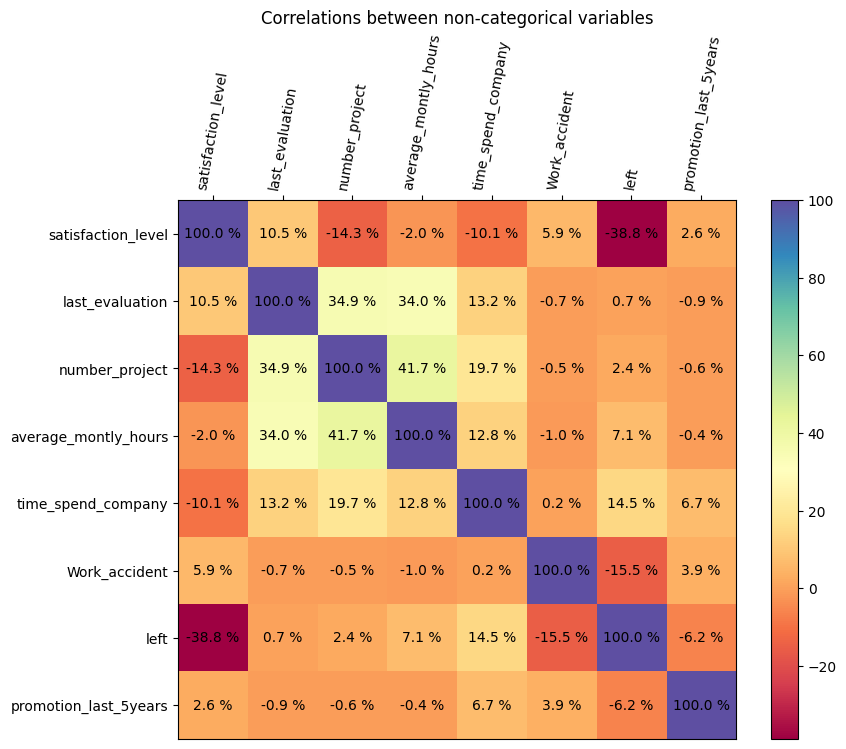

In [10]:
# Correlations
plt.figure(figsize = (9, 7))
        
corr_data = Data.select_dtypes(["int","float"]).corr() * 100
plt.imshow(corr_data, cmap='Spectral', aspect='auto', origin='upper')
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

plt.xticks(*list(zip(*enumerate(corr_data.columns))), rotation=80)
plt.yticks(*list(zip(*enumerate(corr_data.columns))), rotation=0)

for y in range(corr_data.shape[0]):
    for x in range(corr_data.shape[1]):
        plt.text(x, y,'{:.1f} %'.format(corr_data.values[y, x]),
                 horizontalalignment='center',
                 verticalalignment='center')
        
plt.colorbar()
plt.title('Correlations between non-categorical variables')
plt.show()
del(x , y, corr_data)

## Splitting the data

In [11]:
X = Data.drop('left', axis = 1)
y = Data['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic regression

In [66]:
preprocess_pipeline =  ColumnTransformer(transformers = [('numerical', StandardScaler(),  Data.drop('left', axis = 1).select_dtypes(['float','int']).columns), 
                                                         ('categorical', OneHotEncoder(), Data.select_dtypes(['object']).columns)],
                                         remainder='passthrough')

logistic_regression_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), ('classifier', LogisticRegression())])
logistic_regression_pipeline.fit(X_train, y_train)

y_pred = logistic_regression_pipeline.predict(X_test)

print("Logistic regression accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

Logistic regression accuracy: 0.7843
Confusion matrix:
[[2116  178]
 [ 469  237]]
              precision    recall  f1-score   support

           0     0.8186    0.9224    0.8674      2294
           1     0.5711    0.3357    0.4228       706

    accuracy                         0.7843      3000
   macro avg     0.6948    0.6291    0.6451      3000
weighted avg     0.7603    0.7843    0.7628      3000



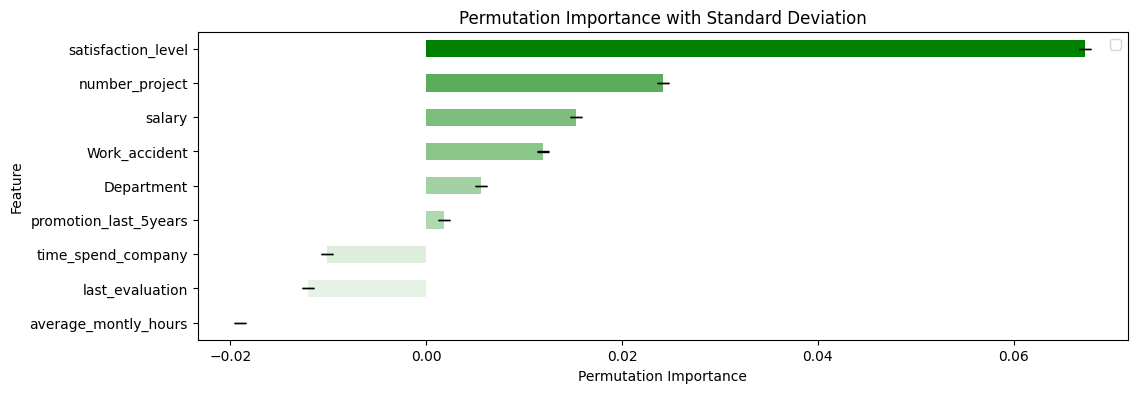

In [13]:
# Feature importance
cmap = LinearSegmentedColormap.from_list('Green',["w", "g"], N=256)

result = permutation_importance(logistic_regression_pipeline, X_test, y_test, n_repeats=100, random_state=42)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean,  
                                   'Standard Deviation': result.importances_std}).sort_values('Importance', ascending=True)

feature_importance.plot(x = 'Feature', y = 'Importance', kind = 'barh', figsize = (12, 4), yerr='Standard Deviation', capsize=4, align='center', legend = False,
                        color = cmap(((feature_importance['Importance']-feature_importance['Importance'].min()) / feature_importance['Importance'].max() * 256
                                     ).map(int)))
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance with Standard Deviation')
plt.legend("")

plt.show()
del(cmap, result, feature_importance, logistic_regression_pipeline)

## Decison Trees

In [64]:
decision_tree_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))])

decision_tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  Index(['Department', 'salary'], dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

In [ ]:
# # TO FIX THE Graphvis PATH ISSUE on WINDOWS:
# # Filter out all the paths with 'Graphviz' in them and the only correct one
# correct_path = r"C:\Program Files\Graphviz\bin" 
# path_to_remove = r"Graphviz"
# os.environ["PATH"] = os.pathsep.join(
#     [p for p in os.environ["PATH"].split(os.pathsep) if not(path_to_remove in p)]) + os.pathsep + correct_path
# # Verify the updated PATH
# print([f for f in os.environ["PATH"].split(';') if 'Graph' in f])

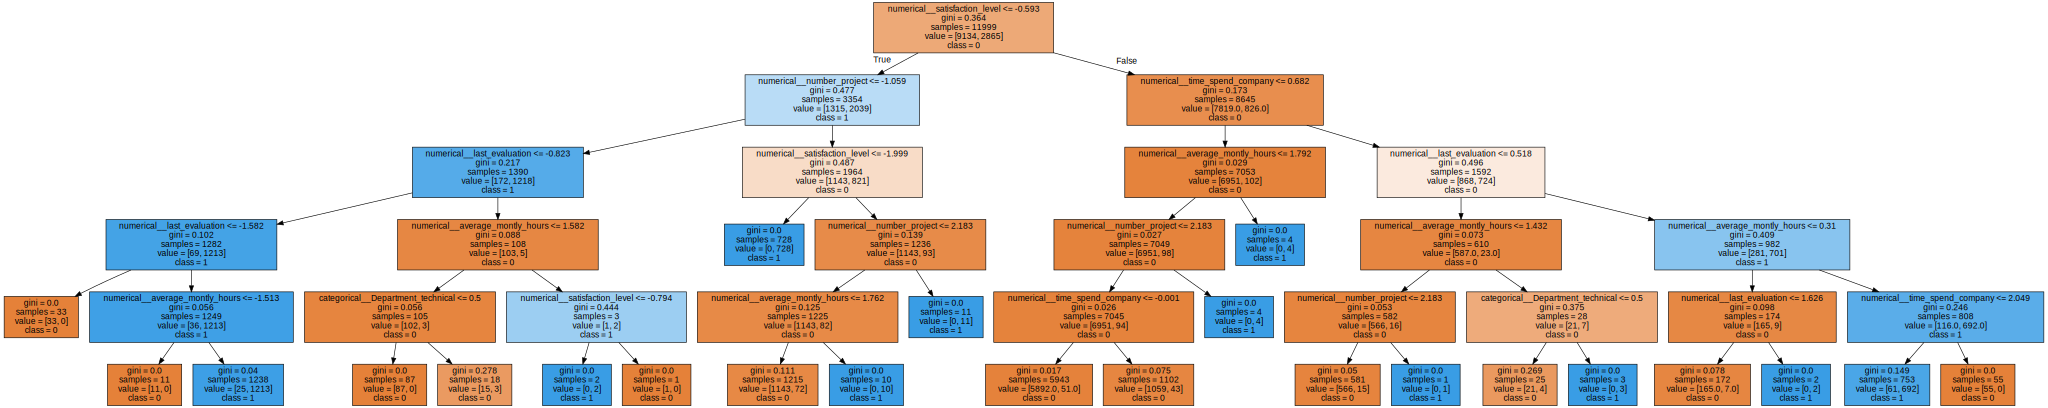

In [16]:
# Showing the tree
SVG(Source(tree.export_graphviz(decision_tree_pipeline.named_steps['classifier'], out_file=None, filled=True,
                                feature_names=decision_tree_pipeline.named_steps['preprocessor'].get_feature_names_out(), 
                                class_names=[str(c) for c in decision_tree_pipeline.classes_]
                               )).pipe(format='svg'))

In [65]:
y_pred = decision_tree_pipeline.predict(X_test)

print("Decision Tree accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
del(y_pred)

Decision Tree accuracy: 0.9713
Confusion matrix:
[[2263   31]
 [  55  651]]
              precision    recall  f1-score   support

           0     0.9763    0.9865    0.9814      2294
           1     0.9545    0.9221    0.9380       706

    accuracy                         0.9713      3000
   macro avg     0.9654    0.9543    0.9597      3000
weighted avg     0.9712    0.9713    0.9712      3000



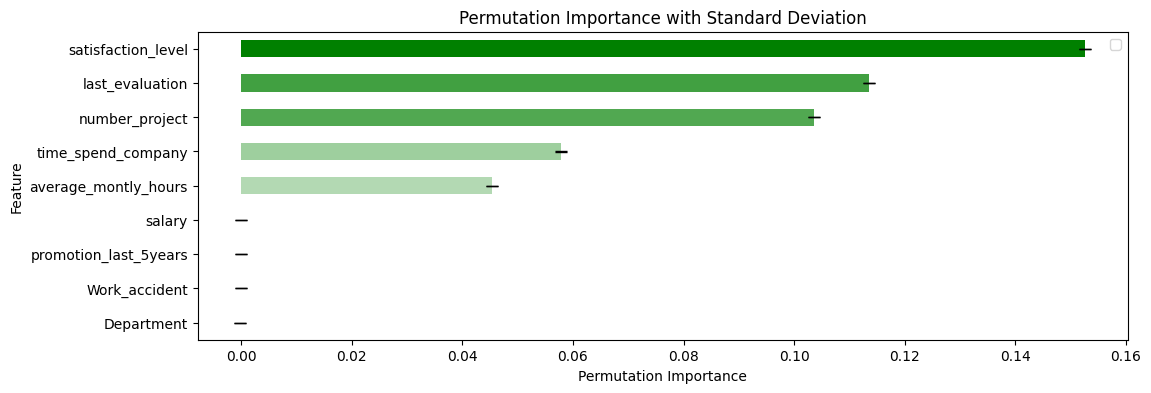

In [18]:
# Feature importance
cmap = LinearSegmentedColormap.from_list('Green',["w", "g"], N=256)

result = permutation_importance(decision_tree_pipeline, X_test, y_test, n_repeats=100, random_state=42)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean,  
                                   'Standard Deviation': result.importances_std}).sort_values('Importance', ascending=True)

feature_importance.plot(x = 'Feature', y = 'Importance', kind = 'barh', figsize = (12, 4), yerr='Standard Deviation', capsize=4, align='center', legend = False,
                        color = cmap(((feature_importance['Importance']-feature_importance['Importance'].min()) / feature_importance['Importance'].max() * 256
                                     ).map(int)))
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance with Standard Deviation')
plt.legend("")

plt.show()
del(cmap, result, feature_importance, decision_tree_pipeline)

In [19]:
# Various scores and averages for the varying maximal depth of the tree
D = dict()
for md in range(1, 17):
    for score, averaging in itertools.product([f1_score, precision_score, recall_score],['binary','macro','micro','weighted']):
        decision_tree_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), ('classifier', DecisionTreeClassifier(max_depth=md, random_state=42))])
        decision_tree_pipeline.fit(X_train, y_train)
        y_pred = decision_tree_pipeline.predict(X_test)
        D[(score.__name__, averaging, md)] = round(score(y_test, y_pred, average=averaging), 4)
display(pd.Series(D.values(), index = pd.MultiIndex.from_tuples(D.keys(), names=['Score','Averaging','Maximal_Depth'])).unstack([-1]))
del(D, md, score, averaging, decision_tree_pipeline, y_pred)

Maximal_Depth                  1       2       3       4       5       6   \
Score           Averaging                                                   
f1_score        binary     0.6410  0.5917  0.8980  0.9295  0.9380  0.9438   
                macro      0.7588  0.7521  0.9329  0.9541  0.9597  0.9636   
                micro      0.8163  0.8560  0.9510  0.9673  0.9713  0.9743   
                weighted   0.8212  0.8371  0.9513  0.9672  0.9712  0.9741   
precision_score binary     0.5935  0.8892  0.8803  0.9444  0.9545  0.9729   
                macro      0.7475  0.8704  0.9271  0.9593  0.9654  0.9738   
                micro      0.8163  0.8560  0.9510  0.9673  0.9713  0.9743   
                weighted   0.8290  0.8604  0.9519  0.9671  0.9712  0.9743   
recall_score    binary     0.6969  0.4433  0.9164  0.9150  0.9221  0.9164   
                macro      0.7750  0.7132  0.9390  0.9492  0.9543  0.9543   
                micro      0.8163  0.8560  0.9510  0.9673  0.9713  0.9743   
                weighted   0.8163  0.8560  0.9510  0.9673  0.9713  0.9743   

Maximal_Depth                  7       8       9       10      11      12  \
Score           Averaging                                                   
f1_score        binary     0.9475  0.9493  0.9536  0.9546  0.9465  0.9494   
                macro      0.9660  0.9671  0.9699  0.9705  0.9651  0.9670   
                micro      0.9760  0.9767  0.9787  0.9790  0.9750  0.9763   
                weighted   0.9758  0.9765  0.9785  0.9789  0.9749  0.9763   
precision_score binary     0.9760  0.9704  0.9763  0.9721  0.9540  0.9555   
                macro      0.9760  0.9744  0.9778  0.9766  0.9677  0.9691   
                micro      0.9760  0.9767  0.9787  0.9790  0.9750  0.9763   
                weighted   0.9760  0.9766  0.9786  0.9789  0.9749  0.9763   
recall_score    binary     0.9207  0.9292  0.9320  0.9377  0.9391  0.9433   
                macro      0.9569  0.9602  0.9625  0.9647  0.9626  0.9649   
                micro      0.9760  0.9767  0.9787  0.9790  0.9750  0.9763   
                weighted   0.9760  0.9767  0.9787  0.9790  0.9750  0.9763   

Maximal_Depth                  13      14      15      16  
Score           Averaging                                  
f1_score        binary     0.9540  0.9507  0.9501  0.9504  
                macro      0.9699  0.9677  0.9673  0.9674  
                micro      0.9783  0.9767  0.9763  0.9763  
                weighted   0.9783  0.9767  0.9764  0.9764  
precision_score binary     0.9533  0.9454  0.9428  0.9379  
                macro      0.9697  0.9659  0.9648  0.9633  
                micro      0.9783  0.9767  0.9763  0.9763  
                weighted   0.9783  0.9768  0.9765  0.9767  
recall_score    binary     0.9547  0.9561  0.9575  0.9632  
                macro      0.9701  0.9695  0.9698  0.9718  
                micro      0.9783  0.9767  0.9763  0.9763  
                weighted   0.9783  0.9767  0.9763  0.9763

## Bagging

In [62]:
bagging_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                   ('classifier', BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_features=10, max_samples=1., 
                                                                    bootstrap_features=False, bootstrap=True, random_state=42, verbose=0))])
bagging_pipeline.fit(X_train, y_train)
y_pred = bagging_pipeline.predict(X_test)
print("Bagging accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
del(bagging_pipeline, y_pred)

Bagging accuracy: 0.9867
Confusion matrix:
[[2292    2]
 [  38  668]]
              precision    recall  f1-score   support

           0     0.9837    0.9991    0.9913      2294
           1     0.9970    0.9462    0.9709       706

    accuracy                         0.9867      3000
   macro avg     0.9904    0.9727    0.9811      3000
weighted avg     0.9868    0.9867    0.9865      3000



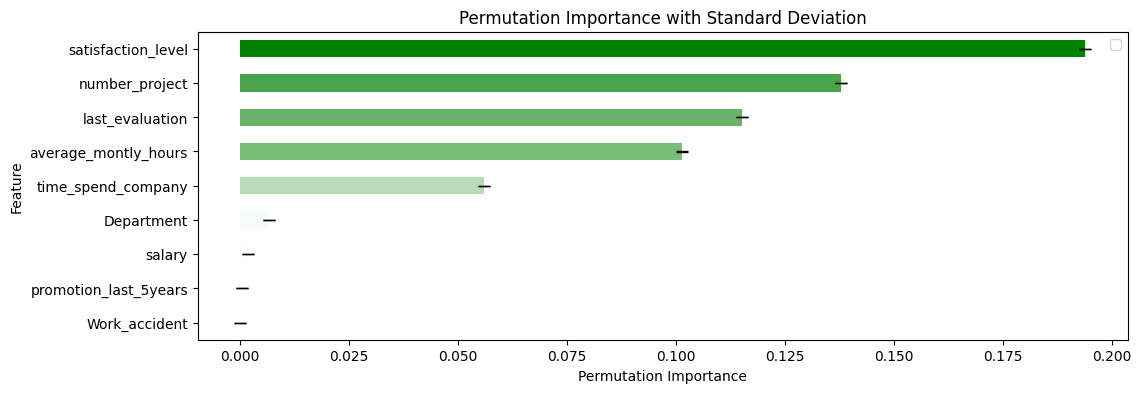

In [21]:
# Feature Importance
cmap = LinearSegmentedColormap.from_list('Green',["w", "g"], N=256)

bagging_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                   ('classifier', BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_features=20, max_samples=1., 
                                                                    bootstrap_features=False, bootstrap=True, random_state=42, verbose=0))])
bagging_pipeline.fit(X_train, y_train)

result = permutation_importance(bagging_pipeline, X_test, y_test, n_repeats=10, random_state=42)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean,  
                                   'Standard Deviation': result.importances_std}).sort_values('Importance', ascending=True)

feature_importance.plot(x = 'Feature', y = 'Importance', kind = 'barh', figsize = (12, 4), yerr='Standard Deviation', capsize=4, align='center', legend = False,
                        color = cmap(((feature_importance['Importance']-feature_importance['Importance'].min()) / feature_importance['Importance'].max() * 256
                                     ).map(int)))
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance with Standard Deviation')
plt.legend("")

plt.show()
#del(cmap, result, feature_importance, bagging_pipeline, y_pred)

In [22]:
# Comparing Bagging and Random Forest (should be the same in theory)
# and evaluating the feature importance using the built-in Random Forest method

bagging_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                   ('classifier', BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_features=10, random_state=42))])
bagging_pipeline.fit(X_train, y_train)
y_pred_bagging = bagging_pipeline.predict(X_test)

random_forest_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                   ('classifier', RandomForestClassifier(n_estimators=500, max_features=10, random_state=42))])
random_forest_pipeline.fit(X_train, y_train)
y_pred_random_forest = random_forest_pipeline.predict(X_test)

print('Disagreement (in %) between Bagging and Random Forest: {} %'.format(round(100 * np.mean(y_pred_bagging != y_pred_random_forest), 2)))
print('Feature importances for Random Forest:')
display(pd.Series(random_forest_pipeline['classifier'].feature_importances_, 
                  index = preprocess_pipeline.fit(X_train).get_feature_names_out()).sort_values(ascending=False).to_frame('Feature Importance'))
del(bagging_pipeline, y_pred_bagging,random_forest_pipeline, y_pred_random_forest)

Disagreement (in %) between Bagging and Random Forest: 0.57 %
Feature importances for Random Forest:


,Feature Importance
numerical__satisfaction_level,0.387102
numerical__time_spend_company,0.175798
numerical__number_project,0.164467
numerical__average_montly_hours,0.130985
numerical__last_evaluation,0.115679
categorical__salary_low,0.003520
categorical__Department_technical,0.003193
numerical__Work_accident,0.002881
categorical__Department_sales,0.002774
categorical__salary_medium,0.002399


In [23]:
# Bagging's F1-score as a function of Num. of Features and Num. of Estimators
D = dict()
for n_est, max_feat in itertools.product([500, 1000, 1500],[4, 9, 14]):
    bagging_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                       ('classifier', BaggingClassifier(DecisionTreeClassifier(), n_estimators=n_est, max_features=max_feat, max_samples=1., 
                                                                        bootstrap_features=False, bootstrap=True, random_state=42, verbose=0))])
    bagging_pipeline.fit(X_train, y_train)
    y_pred = bagging_pipeline.predict(X_test)
    print('n_estimators={}, max_features={}'.format(n_est, max_feat))
    D[(n_est, max_feat)]=round(f1_score(y_test, y_pred, average='binary'),4)
display(pd.Series(D.values(), index = pd.MultiIndex.from_tuples(D.keys(), names=['Num. of Estimators','Num. of Features'])).unstack([-1]))
del(D, n_est, max_feat, bagging_pipeline)

n_estimators=500, max_features=4
n_estimators=500, max_features=9
n_estimators=500, max_features=14
n_estimators=1000, max_features=4
n_estimators=1000, max_features=9
n_estimators=1000, max_features=14
n_estimators=1500, max_features=4
n_estimators=1500, max_features=9
n_estimators=1500, max_features=14


Num. of Features,4,9,14
Num. of Estimators,,,
500,0.7250,0.9604,0.9763
1000,0.6895,0.9604,0.9770
1500,0.6944,0.9604,0.9770


In [24]:
# Out-of-bag (validation) score
bagging_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                   ('classifier', BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_features=10, max_samples=1., 
                                                                    bootstrap_features=False, bootstrap=True, random_state=42, verbose=0,
                                                                    oob_score=True))])
bagging_pipeline.fit(X_train, y_train)
print('Out-of-bag score: {} %'.format(round(100 * bagging_pipeline["classifier"].oob_score_, 3)))
del(bagging_pipeline)

Out-of-bag score: 98.792 %


## AdaBoost

In [61]:
ada_boost_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                     ('classifier', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, 
                                                                       # algorithm="SAMME", 
                                                                       learning_rate=0.5, random_state=42))])
ada_boost_pipeline.fit(X_train, y_train)

y_pred = ada_boost_pipeline.predict(X_test)
print("Bagging accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
del(ada_boost_pipeline, y_pred)

Bagging accuracy: 0.9140
Confusion matrix:
[[2244   50]
 [ 208  498]]
              precision    recall  f1-score   support

           0     0.9152    0.9782    0.9456      2294
           1     0.9088    0.7054    0.7943       706

    accuracy                         0.9140      3000
   macro avg     0.9120    0.8418    0.8699      3000
weighted avg     0.9137    0.9140    0.9100      3000



In [26]:
# Various scores and averages for the varying maximal depth
D = dict()
for md in range(1, 6):
    print('Maximal depth {}'.format(md), end=" ")
    start_time = time.time()
    for score, averaging in itertools.product([f1_score, precision_score, recall_score],['binary','macro','micro','weighted']):
        ada_boost_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                             ('classifier', AdaBoostClassifier(DecisionTreeClassifier(max_depth=md), n_estimators=200, 
                                                                               learning_rate=0.5, random_state=42))])
        ada_boost_pipeline.fit(X_train, y_train)
        y_pred = ada_boost_pipeline.predict(X_test)        
        D[(score.__name__, averaging, md)] = round(score(y_test, y_pred, average=averaging), 4)
    end_time = time.time()
    print(f"(elapsed time: {end_time - start_time:.2f} seconds)")
display(pd.Series(D.values(), index = pd.MultiIndex.from_tuples(D.keys(), names=['Score','Averaging','Maximal_Depth'])).unstack([-1]))
del(D, md, score, averaging, ada_boost_pipeline, y_pred, end_time, start_time)

Maximal depth 1 (elapsed time: 15.22 seconds)
Maximal depth 2 (elapsed time: 20.95 seconds)
Maximal depth 3 (elapsed time: 27.16 seconds)
Maximal depth 4 (elapsed time: 33.44 seconds)
Maximal depth 5 (elapsed time: 40.36 seconds)


Maximal_Depth                   1       2       3       4       5
Score           Averaging                                        
f1_score        binary     0.7943  0.9317  0.9440  0.9442  0.9492
                macro      0.8699  0.9555  0.9635  0.9638  0.9670
                micro      0.9140  0.9683  0.9740  0.9743  0.9767
                weighted   0.9100  0.9682  0.9739  0.9741  0.9765
precision_score binary     0.9088  0.9460  0.9577  0.9659  0.9732
                macro      0.9120  0.9605  0.9683  0.9714  0.9754
                micro      0.9140  0.9683  0.9740  0.9743  0.9767
                weighted   0.9137  0.9681  0.9739  0.9742  0.9766
recall_score    binary     0.7054  0.9178  0.9306  0.9235  0.9263
                macro      0.8418  0.9509  0.9590  0.9567  0.9592
                micro      0.9140  0.9683  0.9740  0.9743  0.9767
                weighted   0.9140  0.9683  0.9740  0.9743  0.9767

In [27]:
# Various scores and averages for the varying number of estimators
D = dict()
for ne in [150, 250, 350, 450]:
    print('Number of Estimators: {}'.format(ne))
    for score, averaging in itertools.product([f1_score, precision_score, recall_score],['binary','macro','micro','weighted']):
        ada_boost_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                             ('classifier', AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=ne, 
                                                                               # algorithm="SAMME", 
                                                                               learning_rate=0.5, random_state=42))])
        ada_boost_pipeline.fit(X_train, y_train)
        y_pred = ada_boost_pipeline.predict(X_test)        
        D[(score.__name__, averaging, ne)] = round(score(y_test, y_pred, average=averaging), 4)
display(pd.Series(D.values(), index = pd.MultiIndex.from_tuples(D.keys(), names=['Score','Averaging','Number of Estimators'])).unstack([-1]))
del(D, ne, score, averaging, ada_boost_pipeline, y_pred)

Number of Estimators: 150
Number of Estimators: 250
Number of Estimators: 350
Number of Estimators: 450


Number of Estimators          150     250     350     450
Score           Averaging                                
f1_score        binary     0.9308  0.9336  0.9346  0.9338
                macro      0.9550  0.9568  0.9574  0.9569
                micro      0.9680  0.9693  0.9697  0.9693
                weighted   0.9678  0.9691  0.9695  0.9692
precision_score binary     0.9472  0.9515  0.9489  0.9488
                macro      0.9607  0.9630  0.9624  0.9621
                micro      0.9680  0.9693  0.9697  0.9693
                weighted   0.9678  0.9691  0.9695  0.9691
recall_score    binary     0.9150  0.9164  0.9207  0.9193
                macro      0.9497  0.9510  0.9527  0.9520
                micro      0.9680  0.9693  0.9697  0.9693
                weighted   0.9680  0.9693  0.9697  0.9693

In [28]:
# Various scores and averages for the varying learning rate
D = dict()
for lr in [.2, 0.5, 0.7]:
    print('Learning rate: {}'.format(lr))
    for score, averaging in itertools.product([f1_score, precision_score, recall_score],['binary','macro','micro','weighted']):
        ada_boost_pipeline = Pipeline(steps=[('preprocessor', preprocess_pipeline), 
                                             ('classifier', AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=200, 
                                                                               #algorithm="SAMME", 
                                                                               learning_rate=lr, random_state=42))])
        ada_boost_pipeline.fit(X_train, y_train)
        y_pred = ada_boost_pipeline.predict(X_test)        
        D[(score.__name__, averaging, lr)] = round(score(y_test, y_pred, average=averaging), 4)
display(pd.Series(D.values(), index = pd.MultiIndex.from_tuples(D.keys(), names=['Score','Averaging','Learning rate'])).unstack([-1]))
del(D, lr, score, averaging, ada_boost_pipeline, y_pred)

Learning rate: 0.2
Learning rate: 0.5
Learning rate: 0.7


Learning rate                 0.2     0.5     0.7
Score           Averaging                        
f1_score        binary     0.9199  0.9317  0.9330
                macro      0.9479  0.9555  0.9563
                micro      0.9630  0.9683  0.9687
                weighted   0.9627  0.9682  0.9686
precision_score binary     0.9381  0.9460  0.9397
                macro      0.9542  0.9605  0.9585
                micro      0.9630  0.9683  0.9687
                weighted   0.9627  0.9681  0.9685
recall_score    binary     0.9023  0.9178  0.9263
                macro      0.9420  0.9509  0.9540
                micro      0.9630  0.9683  0.9687
                weighted   0.9630  0.9683  0.9687

## XGBoost

In [89]:
xg_boost =  xgboost.XGBClassifier(enable_categorical=True, random_state=42, max_depth=8, min_child_weight=0.5, 
                                  n_estimators=100, gamma=3., reg_alpha=1., reg_lambda=1.)
xg_boost.fit(X_train.apply(lambda col: col.astype('category') if col.dtype == 'object' else col, axis = 0), y_train)

y_pred = xg_boost.predict(X_test.apply(lambda col: col.astype('category') if col.dtype == 'object' else col, axis = 0))

print("XG-Boost accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print('---------------------')
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print('---------------------')
print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))
del(xg_boost, y_pred)

XG-Boost accuracy: 0.9787
---------------------
Confusion matrix:
[[2286    8]
 [  56  650]]
---------------------
Classification report:
              precision    recall  f1-score   support

           0     0.9761    0.9965    0.9862      2294
           1     0.9878    0.9207    0.9531       706

    accuracy                         0.9787      3000
   macro avg     0.9820    0.9586    0.9696      3000
weighted avg     0.9789    0.9787    0.9784      3000



In [93]:
# The F1 score for various XG-Boost hyperparameters
D = dict()
# gamma = minimum loss reduction, reg_alpha = L1 regularization term on weights, reg_lambda = L2 weight regularization
# min_child_weight = Minimum sum of instance weight (hessian) needed in a child node.
# max_depth = The maximum depth of the trees. Higher values will make the model more complex and can lead to overfitting

for g, a, l, md, mcw in itertools.product([0, 0.4, 0.8], [0.1], [0.1], [4, 8, 12, 16], [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.5]):
    xg_boost =  xgboost.XGBClassifier(enable_categorical=True, random_state=42, max_depth = md,  min_child_weight = mcw,
                                      gamma=g, reg_alpha=a, reg_lambda=l)
    xg_boost.fit(X_train.apply(lambda col: col.astype('category') if col.dtype == 'object' else col, axis = 0), y_train)

    y_pred = xg_boost.predict(X_test.apply(lambda col: col.astype('category') if col.dtype == 'object' else col, axis = 0))    
    D[(g, a, l, md, mcw)] = round(f1_score(y_test, y_pred, average='binary'), 4)
display(pd.Series(D.values(), index = pd.MultiIndex.from_tuples(D.keys(), names=['Gamma','Reg. Alpha','Reg. Lambda',
                                                                                 'Maximal Depth', 'Minimal Child Weight'])).unstack([0]))
del(D, g, a, l, xg_boost, y_pred)

Gamma                                                     0.0     0.4     0.8
Reg. Alpha Reg. Lambda Maximal Depth Min Child Weight                        
0.1        0.1         4             0.4               0.9635  0.9620  0.9486
                                     0.6               0.9628  0.9547  0.9516
                                     0.8               0.9620  0.9568  0.9509
                                     1.0               0.9626  0.9546  0.9493
                                     1.2               0.9627  0.9524  0.9457
                                     1.4               0.9627  0.9560  0.9502
                                     1.5               0.9613  0.9598  0.9514
                       8             0.4               0.9749  0.9720  0.9670
                                     0.6               0.9749  0.9706  0.9662
                                     0.8               0.9757  0.9713  0.9692
                                     1.0               0.9743  0.9713  0.9656
                                     1.2               0.9736  0.9699  0.9677
                                     1.4               0.9743  0.9677  0.9640
                                     1.5               0.9729  0.9699  0.9675
                       12            0.4               0.9749  0.9763  0.9720
                                     0.6               0.9757  0.9757  0.9713
                                     0.8               0.9750  0.9721  0.9742
                                     1.0               0.9750  0.9721  0.9729
                                     1.2               0.9743  0.9721  0.9720
                                     1.4               0.9722  0.9714  0.9662
                                     1.5               0.9736  0.9707  0.9706
                       16            0.4               0.9749  0.9749  0.9721
                                     0.6               0.9728  0.9735  0.9721
                                     0.8               0.9728  0.9714  0.9734
                                     1.0               0.9722  0.9743  0.9735
                                     1.2               0.9722  0.9757  0.9721
                                     1.4               0.9750  0.9736  0.9713
                                     1.5               0.9722  0.9728  0.9729